In [1]:
import os
import numpy as np
import pandas as pd
import colorsys
import matplotlib.colors as mc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, r2_score, precision_recall_fscore_support
import common.metrics as met
import common.plots as plo
from common.h5py_loading import load_target_map, load_dataset
from common.h5py_data_loader import H5pyDataLoader
from common.prediction_analysis import df_from_chembl_export, intersect_truth_prediction
from lasagne_nn.run_nn import get_predictions_of_knowns, get_network_from_weights
from lasagne_nn.output_loader import df_from_prediction_path

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File 

In [2]:
# data handling

def get_env_var(handle):
    ''' Get an environment variable given the handle for the bash variable'''
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")

def get_preds(dset_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if dset_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
    return prediction, truth

def predictions_knowns_from_trained_network_and_data(hdf5_file, weights_filename, build_nn_script,
                                                     test_indices_file=None,
                                                     npKi=False, multitask=False,
                                                     network_target_map_file=None,
                                                     dataset_target_map_file=None):
    network = get_network_from_weights(weights_filename, build_nn=build_nn_script)
    network_target_map = load_target_map(network_target_map_file) if network_target_map_file else None
    data_loader = H5pyDataLoader(hdf5_file=hdf5_file, test_indices_file=test_indices_file,
                                 npKi=npKi, multitask=multitask,
                                 target_map_file=dataset_target_map_file,
                                 train_percentage=None)
    data_loader.load_training_data()
    predictions, knowns = get_predictions_of_knowns(data_loader=data_loader,
                                                    weights_filename=weights_filename,
                                                    indices=data_loader.train_indices,
                                                    network=network,
                                                    network_target_map=network_target_map)
    return predictions, knowns

In [3]:
home_dir = get_env_var("HOME_SAVE_BASE")

In [4]:
!ls $home_dir/output/20180815_Paper_Retrains/trained_nets

all_negs_stochastic  lr_nesterov_1024_2048_3072
cpu_or_gpu	     lr_nesterov_binary_classifier_1024_2048_3072


In [5]:
!ls $home_dir/output/20180815_Paper_Retrains/predictions/

CLASSIFIER_scrambled_idx	 CLASSIFIER_STD_RATIOS	scrambled_idx_no_SMA
CLASSIFIER_scrambled_idx_No_SMA  experiments.json	SEA_SMA
CLASSIFIER_SEA_SMA		 NEG_RM_RATIOS		STD_SMA_RATIOS
CLASSIFIER_SMA_RATIOS		 scrambled_idx		targets


In [6]:
home_dir=get_env_var("HOME_SAVE_BASE")
data_dict = {
    "CLASSIFIER_scrambled_idx_LR01" : {
        "indir": "{}/output/20180815_Paper_Retrains/predictions/CLASSIFIER_scrambled_idx_LR01".format(home_dir),
        "train_base" : "{}/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_scrambled_idx_LR01".format(home_dir),
        "train_dir_fmter" : "{}/fold_{}/pnr_{}",
        "knowns_fmt" : "{}/CLASSIFIER_scrambled_idx_LR01_{}_{}_fold_{}_regression_knowns.npz",
        "preds_fmt" : "{}/CLASSIFIER_scrambled_idx_LR01_{}_{}_fold_{}_regression_preds.npz",
        "npz_fmt" : True, 
        "ratios" : [1.0]
    },
    "CLASSIFIER_scrambled_idx_No_SMA_LR01" : {
        "indir": "{}/output/20180815_Paper_Retrains/predictions/CLASSIFIER_scrambled_idx_No_SMA_LR01".format(home_dir),
        "train_base" : "{}/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_scrambled_idx_No_SMA_LR01".format(home_dir),
        "train_dir_fmter" : "{}/fold_{}/pnr_{}",
        "knowns_fmt" : "{}/CLASSIFIER_scrambled_idx_No_SMA_LR01_{}_{}_fold_{}_regression_knowns.npz",
        "preds_fmt" : "{}/CLASSIFIER_scrambled_idx_No_SMA_LR01_{}_{}_fold_{}_regression_preds.npz",
        "npz_fmt" : True, 
        "ratios" : [1.0]
    },
    "CLASSIFIER_SEA_SMA_LR01" : {
        "indir": "{}/output/20180815_Paper_Retrains/predictions/CLASSIFIER_SEA_SMA_LR01".format(home_dir),
        "train_base" : "{}/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SEA_SMA_LR01".format(home_dir),
        "train_dir_fmter" : "{}/fold_{}/pnr_{}",
        "knowns_fmt" : "{}/CLASSIFIER_SEA_SMA_LR01_{}_{}_fold_{}_regression_knowns.npz",
        "preds_fmt" : "{}/CLASSIFIER_SEA_SMA_LR01_{}_{}_fold_{}_regression_preds.npz",
        "npz_fmt" : True, 
        "ratios" : [1.0]
    },
    "CLASSIFIER_SMA_RATIOS_LR01" : {
        "indir": "{}/output/20180815_Paper_Retrains/predictions/CLASSIFIER_SMA_RATIOS_LR01".format(home_dir),
        "train_base" : "{}/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS_LR01".format(home_dir),
        "train_dir_fmter" : "{}/fold_{}/pnr_{}",
        "knowns_fmt" : "{}/CLASSIFIER_SMA_RATIOS_LR01_{}_{}_fold_{}_regression_knowns.npz",
        "preds_fmt" : "{}/CLASSIFIER_SMA_RATIOS_LR01_{}_{}_fold_{}_regression_preds.npz",
        "npz_fmt" : True,
        "ratios": ["1.0", "1.2222", "0.8182", "1.5", "19.0", "9.0", "4.0", "2.3333", "0.6666", "0.4286", "0.25", "0.1111", "0.0753"]
    },    
    "CLASSIFIER_STD_LR01" : {
        "indir": "{}/output/20180815_Paper_Retrains/predictions/CLASSIFIER_STD_LR01".format(home_dir),
        "train_base" : "{}/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_LR01".format(home_dir),
        "train_dir_fmter" : "{}/fold_{}/pnr_{}",
        "knowns_fmt" : "{}/CLASSIFIER_STD_LR01_{}_{}_fold_{}_regression_knowns.npz",
        "preds_fmt" : "{}/CLASSIFIER_STD_LR01_{}_{}_fold_{}_regression_preds.npz",
        "npz_fmt" : True,
        "ratios": ["1.0", "1.2222", "0.8182", "1.5", "19.0", "9.0", "4.0", "2.3333", "0.6666", "0.4286", "0.25", "0.1111", "0.0753"]
    },}

In [7]:
import common.metrics as metrics
from scipy import interp
reload(plo)

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'common.plots' from '/srv/home/ecaceres/labgits/neural-nets/common/plots.pyc'>

In [8]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Credit: Ian Hincks from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    try:
        c = mc.cnames[color]
    except:
        c = color

    c = colorsys.rgb_to_hls(*mc.colorConverter.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


In [9]:
def plot_k_folds(dset_dict, expt, dset, ax, plot_rand=False, threshold=6.0, ratio=None, x_y_type='tpr-fpr', color="red", amount=0.4):
    first = True
    
    for fold in np.arange(0,5,1):
        prediction, truth = get_preds(dset_dict, expt, dset, fold, ratio=ratio)
        if dset != "drugmatrix":
            known_mask = ~np.isnan(truth)
            truth = truth[known_mask]
            prediction = prediction[known_mask]
        
        auc = plo.plot_binary_auc(prediction, truth, threshold=threshold, plot_rand=False, ax=ax, 
                                  x_y_type='tpr-fpr', show_legend=False, 
                                  **{"color":lighten_color(color, amount=amount)})
        if first:
            preds = prediction
            truths = truth
            first = False
            
        else: 
            preds = np.hstack([preds, prediction])
            truths = np.hstack([truths, truth])

    return preds, truths


def plot_roc_comp(dset_dict, expt_list, dset, save_name=None, thresh=6.0, ratio=None, amount=0.5):
    figsize = (10, 10)
    plt.clf()
    current_palette = sns.color_palette("deep")
    sns.set_palette(current_palette)
    sns.set_context("paper")
    sns.set(font_scale=2)
    sns.set_style("white")

    fig, ax = plt.subplots(figsize=figsize)   
    colors = sns.color_palette("deep", len(expt_list))
    color_counter = 0
    plotting_kwargs = {
        "plot_rand": False,
        "threshold" : thresh,
        "x_y_type" : "tpr-fpr"
    }
    
    concat_data = []
    
    for expt in expt_list:
        plotting_kwargs["color"] = colors[color_counter]
        if dset_dict[expt]["ratios"]:
            plot_ratio=ratio
        else:
            plot_ratio=None
            
        preds, truths = plot_k_folds(dset_dict, expt, dset, ax, 
                                              ratio=plot_ratio, amount = amount, **plotting_kwargs)
        concat_data.append((preds, truths, plotting_kwargs["color"], expt))
        color_counter += 1

    for i in np.arange(0,len(concat_data), 1):
        plotting_kwargs["color"] = concat_data[i][2]
        if i < len(concat_data)-1:
            plotting_kwargs["plot_rand"] = False
        else:
            plotting_kwargs["plot_rand"] = True
        auc = plo.plot_binary_auc(concat_data[i][0], concat_data[i][1], ax=ax, show_legend=False,  
                                  plot_label=concat_data[i][3], **plotting_kwargs)
    
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)
    
    handles, labels = ax.get_legend_handles_labels()
    pylab.legend(handles[-len(expt_list):], labels[-len(expt_list):],loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.tight_layout()
    plt.title("{} AUROC".format(dset))

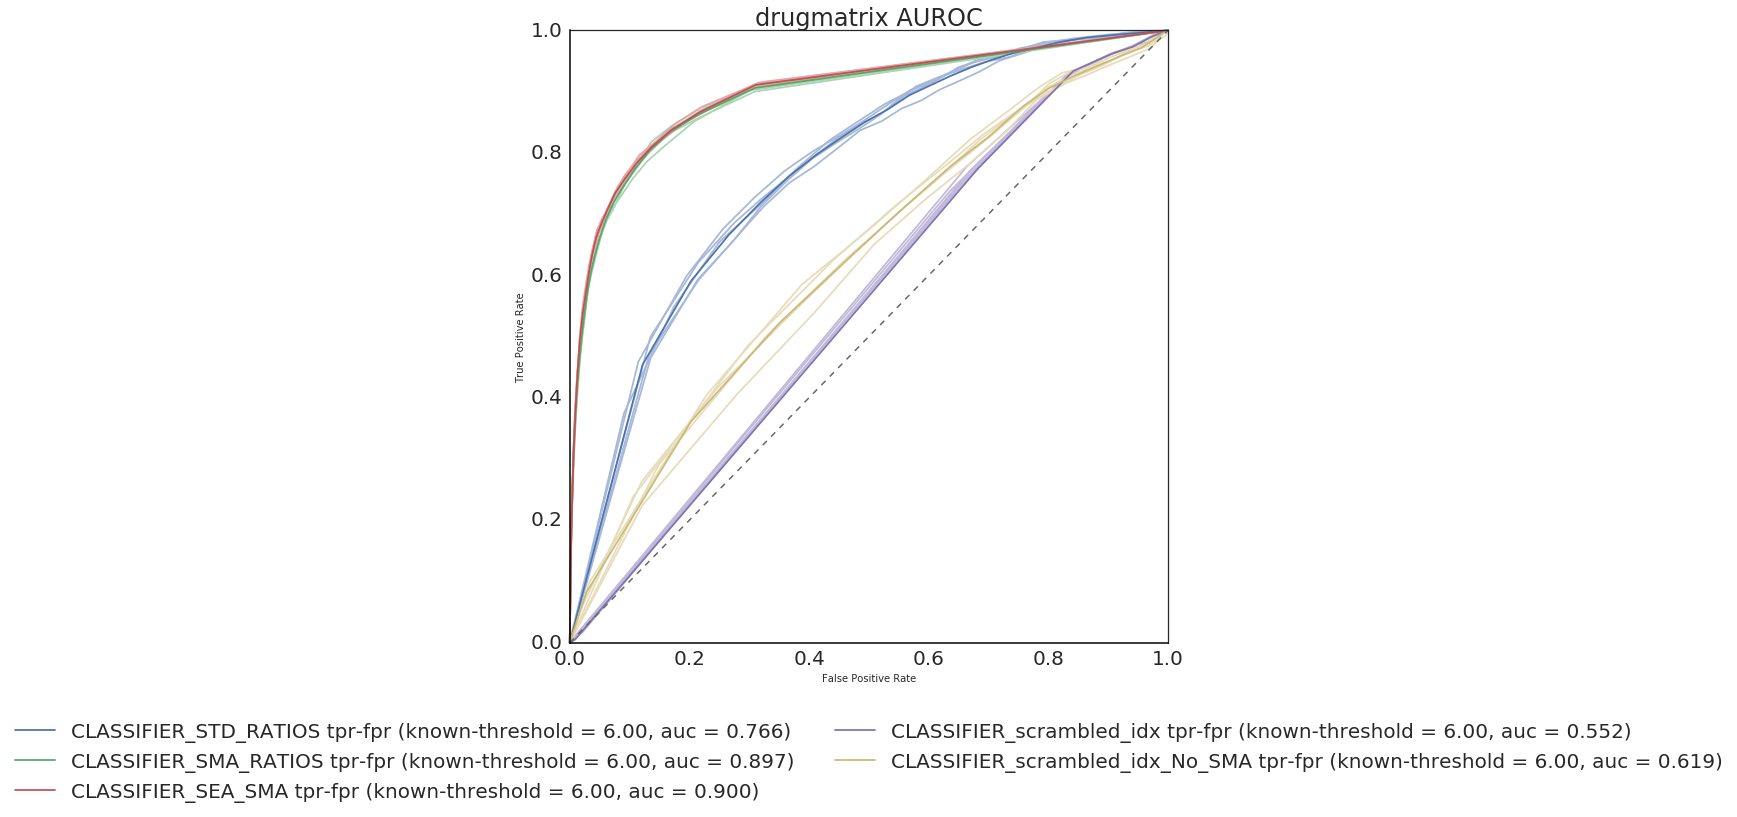

In [10]:
plot_roc_comp(data_dict, ['CLASSIFIER_STD_RATIOS',  'CLASSIFIER_SMA_RATIOS', 
                          'CLASSIFIER_SEA_SMA', 'CLASSIFIER_scrambled_idx',
                          'CLASSIFIER_scrambled_idx_No_SMA',],
              "drugmatrix", save_name=None, thresh=6.0, ratio="1.0", amount=0.5)

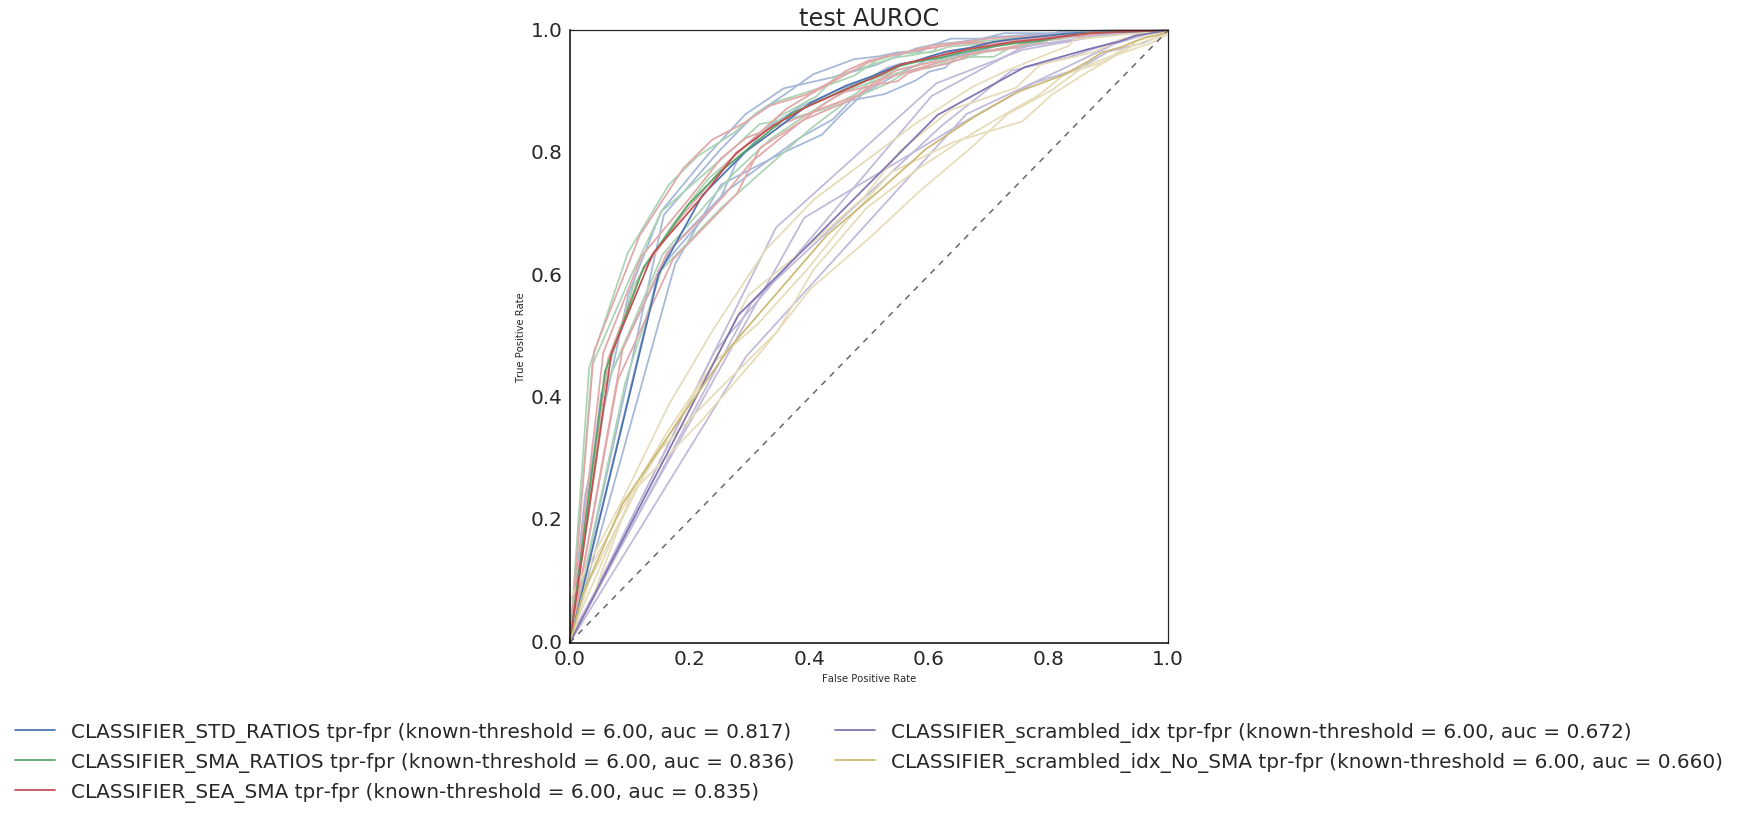

In [11]:
plot_roc_comp(data_dict, ['CLASSIFIER_STD_RATIOS',  'CLASSIFIER_SMA_RATIOS', 
                          'CLASSIFIER_SEA_SMA', 'CLASSIFIER_scrambled_idx',
                          'CLASSIFIER_scrambled_idx_No_SMA',],
              "test", save_name=None, thresh=6.0, ratio="1.0", amount=0.5)

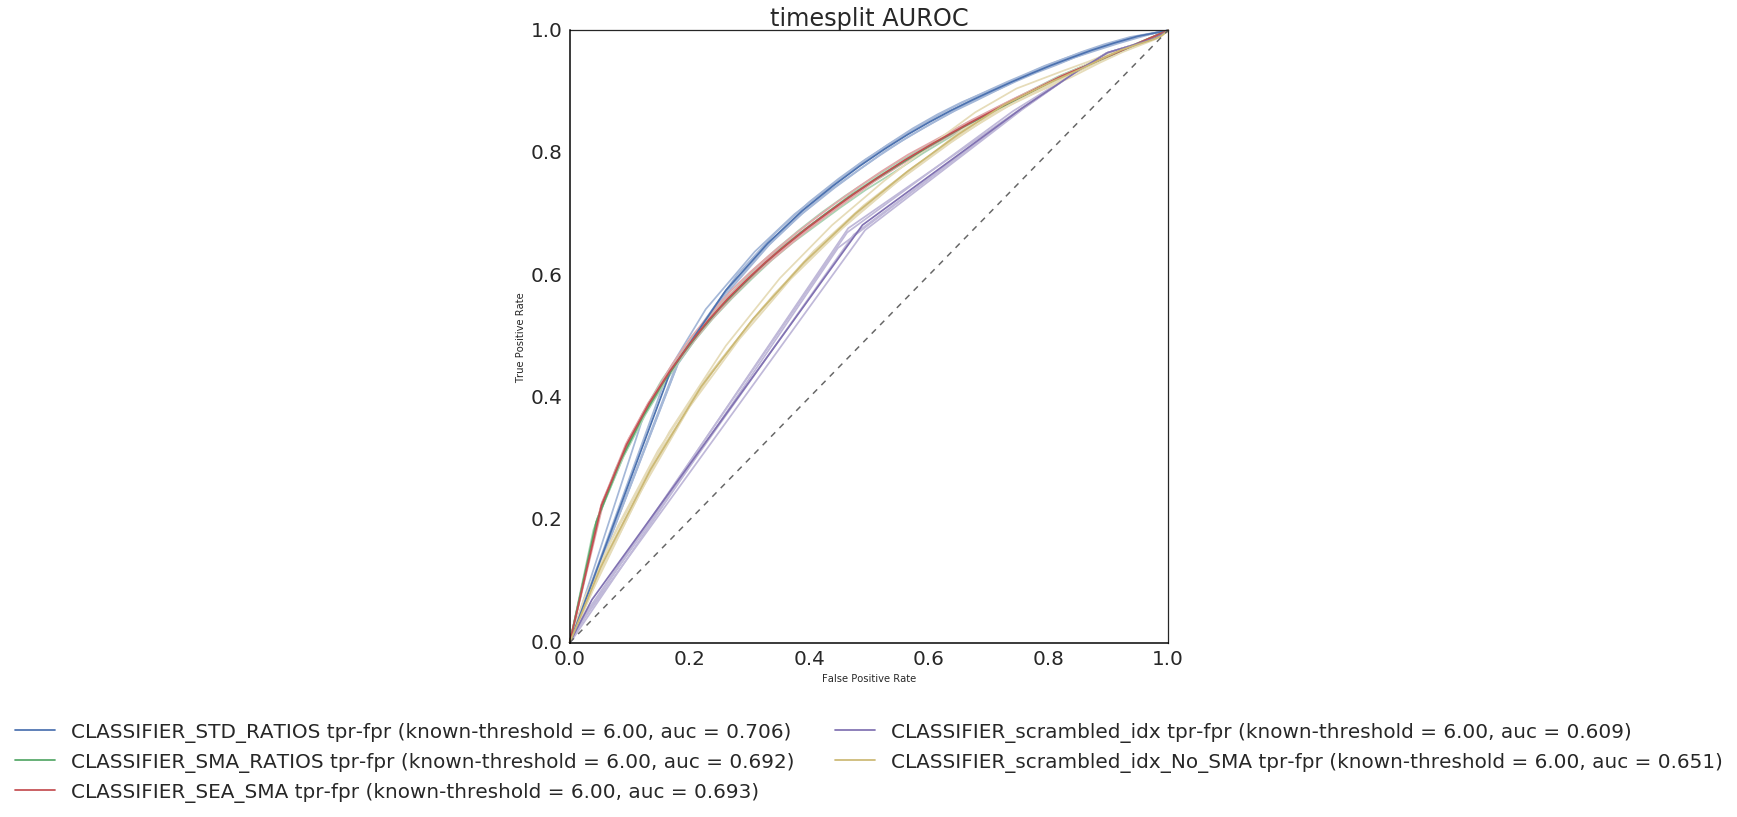

In [12]:
plot_roc_comp(data_dict, ['CLASSIFIER_STD_RATIOS',  'CLASSIFIER_SMA_RATIOS', 
                          'CLASSIFIER_SEA_SMA', 'CLASSIFIER_scrambled_idx',
                          'CLASSIFIER_scrambled_idx_No_SMA',],
              "timesplit", save_name=None, thresh=6.0, ratio="1.0", amount=0.5)

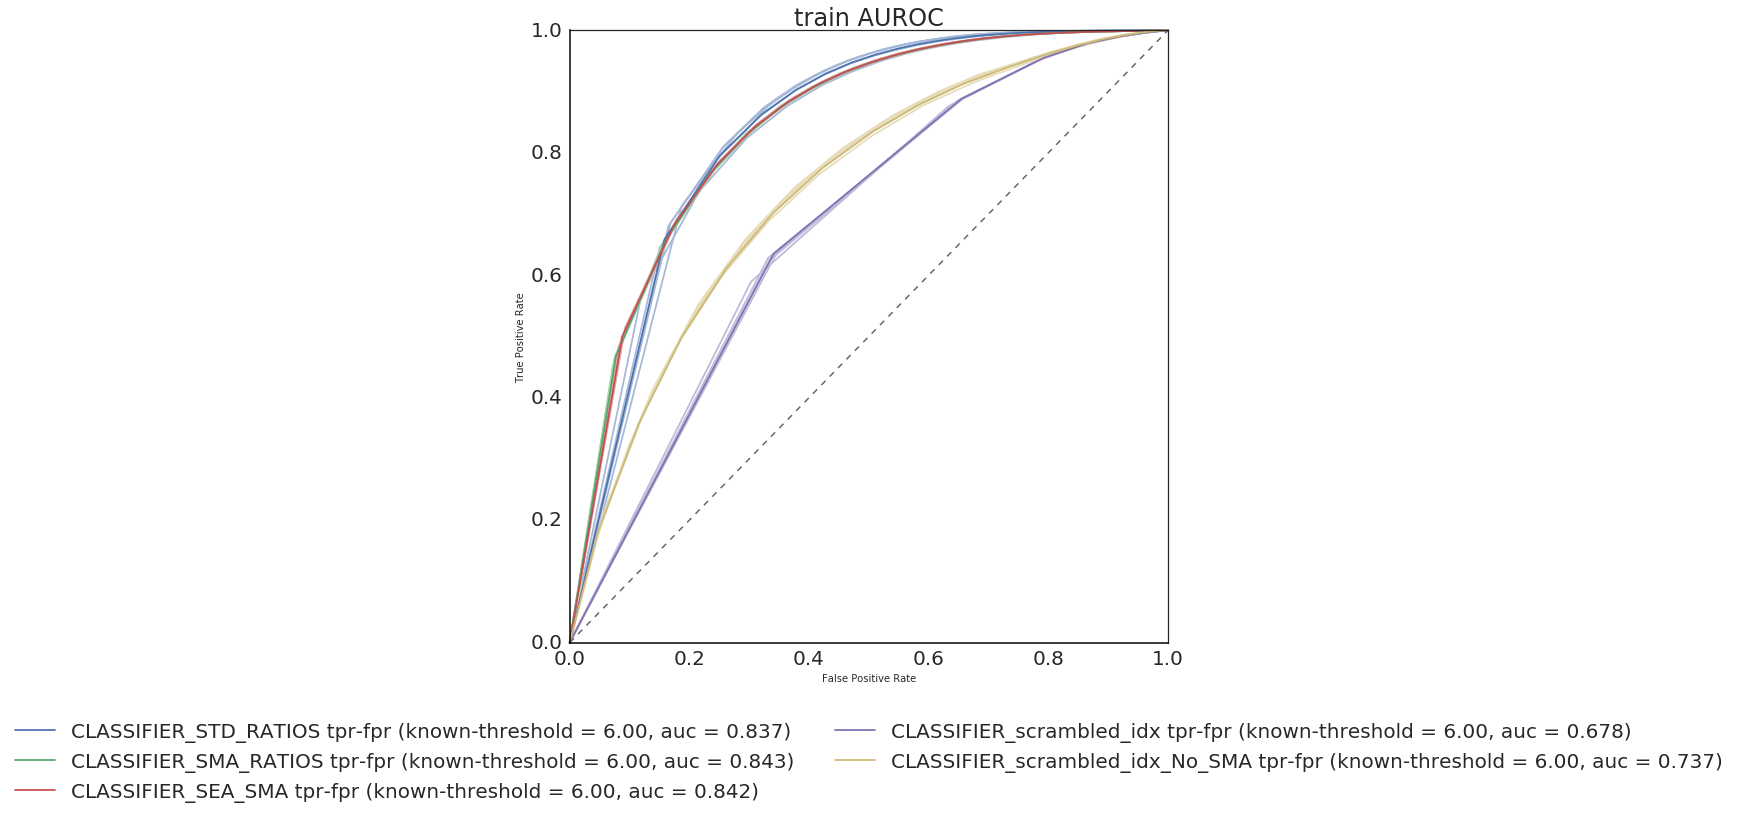

In [13]:
plot_roc_comp(data_dict, ['CLASSIFIER_STD_RATIOS',  'CLASSIFIER_SMA_RATIOS', 
                          'CLASSIFIER_SEA_SMA', 'CLASSIFIER_scrambled_idx',
                          'CLASSIFIER_scrambled_idx_No_SMA',],
              "train", save_name=None, thresh=6.0, ratio="1.0", amount=0.5)